In [3]:
import pandas as pd
import zipfile
import os

# Define the path to the ZIP file
zip_file_path = '/content/Sales-20240705T181800Z-001.zip'

# Initialize an empty list to hold the DataFrames
dfs = []

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # List all files in the ZIP archive
    for filename in z.namelist():
        # Check if the file is a CSV
        if filename.endswith('.csv'):
            # Read the CSV file
            with z.open(filename) as f:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(f)
                # Append the DataFrame to the list
                dfs.append(df)

# Concatenate all DataFrames into a single DataFrame (optional)
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
print(combined_df)


       Order ID                   Product Quantity Ordered Price Each  \
0        141234                    iPhone                1        700   
1        141235  Lightning Charging Cable                1      14.95   
2        141236          Wired Headphones                2      11.99   
3        141237          27in FHD Monitor                1     149.99   
4        141238          Wired Headphones                1      11.99   
...         ...                       ...              ...        ...   
373695   278792     AA Batteries (4-pack)                1       3.84   
373696   278793          Wired Headphones                1      11.99   
373697   278794     AA Batteries (4-pack)                1       3.84   
373698   278795                    iPhone                1        700   
373699   278796          Wired Headphones                1      11.99   

            Order Date                         Purchase Address  
0       01/22/19 21:25          944 Walnut St, Boston, MA

In [4]:
combined_df = df.dropna(subset=['Order ID'])
combined_df = df.dropna(how='all')

In [5]:
combined_df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [7]:
# Drop any rows with missing values in 'Order ID'
combined_df = combined_df.dropna(subset=['Order ID'])

# Remove any rows that are entirely empty
combined_df = combined_df.dropna(how='all')

# Convert 'Order ID' to integers, ignoring errors
combined_df["Order ID"] = pd.to_numeric(combined_df['Order ID'], errors='coerce').astype('Int64')

# Convert other columns to their appropriate types
combined_df["Quantity Ordered"] = pd.to_numeric(combined_df['Quantity Ordered'][1:], errors='coerce').astype('Int64')
combined_df['Price Each'] = pd.to_numeric(combined_df['Price Each'][1:], errors='coerce').astype('float')

# Handle potential date format issues
combined_df['Order Date'] = pd.to_datetime(combined_df['Order Date'], format="%m/%d/%y %H:%M", errors='coerce')

# Display the data types of each column
combined_df.dtypes

Order ID                     Int64
Product                     object
Quantity Ordered             Int64
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
dtype: object

In [8]:
combined_df['Month'] = combined_df['Order Date'].dt.month
combined_df['Day'] = combined_df['Order Date'].dt.day

In [9]:
combined_df['sales'] = combined_df['Quantity Ordered'] * combined_df['Price Each']

In [10]:
combined_df.loc[combined_df.duplicated()]
combined_df = combined_df.drop_duplicates()

In [11]:
# Q: What Was The Best Month for Sales?

group_df = combined_df[['Month', 'sales']].groupby('Month') \
    .sum() \
    .sort_values('sales', ascending=False)

group_df

,sales
Month,
12,4608295.7
10,3734777.86
4,3389217.98
11,3197875.05
5,3150616.23
3,2804973.35
7,2646461.32
6,2576268.2
8,2241083.37


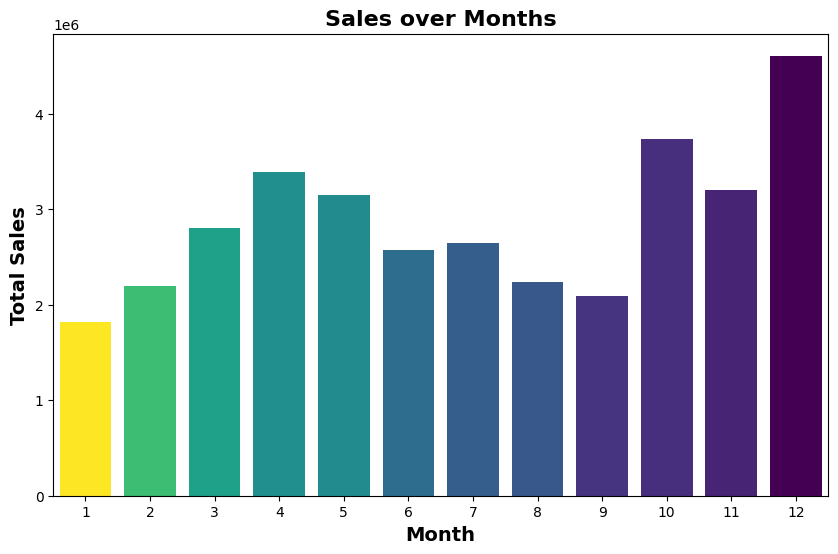

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Extract 1D arrays for month and sales
sales_data = group_df['sales'].values
month_labels = group_df.index

# Color palette selection
color_palette = plt.cm.viridis

# Create a list to store custom colors
custom_colors = []
for sale in sales_data:
  # Normalize sales data (0 to 1)
  normalized_value = (sale - min(sales_data)) / (max(sales_data) - min(sales_data))
  # Get color from the chosen colormap based on normalized value
  custom_color = color_palette(normalized_value)
  custom_colors.append(custom_color)

# Bar plot with custom colors, iterate through colors instead of passing the whole list
ax = sns.barplot(y=sales_data, x=month_labels)
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(custom_colors[i])
plt.xlabel('Month', fontweight="bold", fontsize = 14, color = 'black' )
plt.ylabel('Total Sales', fontweight="bold", fontsize = 14, color = 'black' )
plt.title('Sales over Months', fontweight="bold", fontsize = 16, color = 'black' )

plt.show()

In [71]:
# Remove any non-numeric characters

combined_df = combined_df.dropna(subset=['Price Each'])

combined_df['Price Each'] = combined_df['Price Each'].astype(int)

max_price = combined_df['Price Each'].max()
min_price = combined_df['Price Each'].min()

print(f"Maximum Price: {max_price}")
print(f"Minimum Price: {min_price}")


Maximum Price: 1700
Minimum Price: 2


In [74]:
combined_df['Price Each'].describe()

count    185685.000000
mean        183.773574
std         333.054815
min           2.000000
25%          11.000000
50%          14.000000
75%         150.000000
max        1700.000000
Name: Price Each, dtype: float64

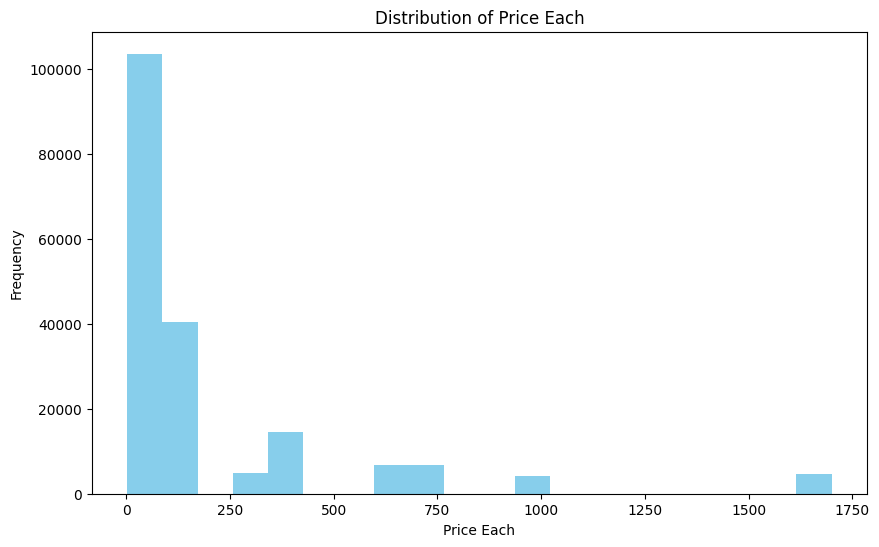

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(combined_df['Price Each'], bins=20, color='skyblue')
plt.xlabel('Price Each')
plt.ylabel('Frequency')
plt.title('Distribution of Price Each')
plt.show()


In [105]:
# Q: Most effected productes (Higher vs Lower Prices), Then compute perecentage per each month.

# Define the threshold for high price
threshold = 500

# Classify products into 'Higher' and 'Lower' price classes
combined_df['price_class'] = combined_df['Price Each'].apply(lambda x: 'Higher' if x > threshold else 'Lower')

# Group by month and price class, and compute the count
grouped = combined_df.groupby(['Month', 'price_class']).size().unstack(fill_value=0)

# Compute the percentage per class per month
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
percentages = percentages.applymap(lambda x: f'{x:.2f}%')

print("Product counts per class per month:")
print(grouped)
print("\nPercentage of products per class per month:")
print(percentages)

Product counts per class per month:
price_class  Higher  Lower
Month                     
1              1232   8467
2              1446  10511
3              1837  13291
4              2252  16005
5              2093  14459
6              1690  11844
7              1705  12570
8              1464  10479
9              1349  10254
10             2408  17841
11             2079  15465
12             2966  21978

Percentage of products per class per month:
price_class  Higher   Lower
Month                      
1            12.70%  87.30%
2            12.09%  87.91%
3            12.14%  87.86%
4            12.33%  87.67%
5            12.64%  87.36%
6            12.49%  87.51%
7            11.94%  88.06%
8            12.26%  87.74%
9            11.63%  88.37%
10           11.89%  88.11%
11           11.85%  88.15%
12           11.89%  88.11%


<Figure size 1000x600 with 0 Axes>

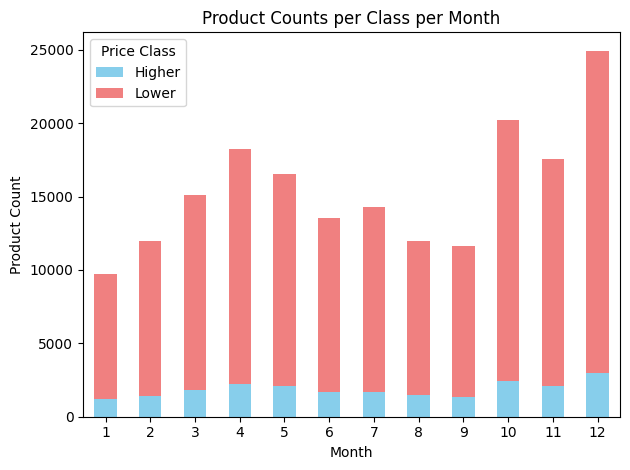

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
grouped.plot(kind='bar', stacked=True, color=['skyblue', 'lightcoral'])
plt.xlabel("Month")
plt.ylabel("Product Count")
plt.title("Product Counts per Class per Month")
plt.legend(title="Price Class")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

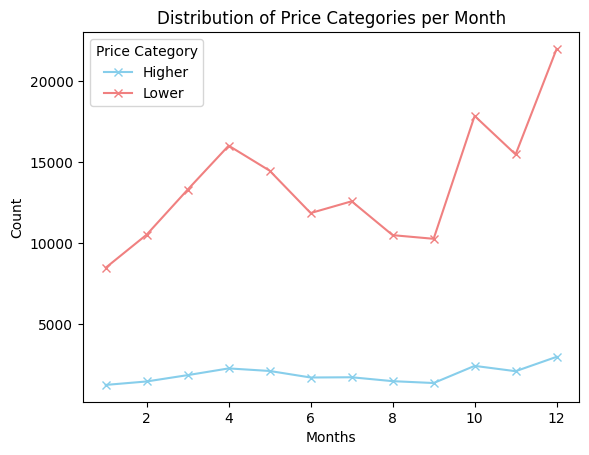

In [101]:
plt.figure(figsize=(12, 10))
grouped.plot(kind='line', marker='x', color=['skyblue', 'lightcoral'])
plt.xlabel('Months')
plt.ylabel('Count')
plt.title('Distribution of Price Categories per Month')
plt.legend(title='Price Category')
plt.show()


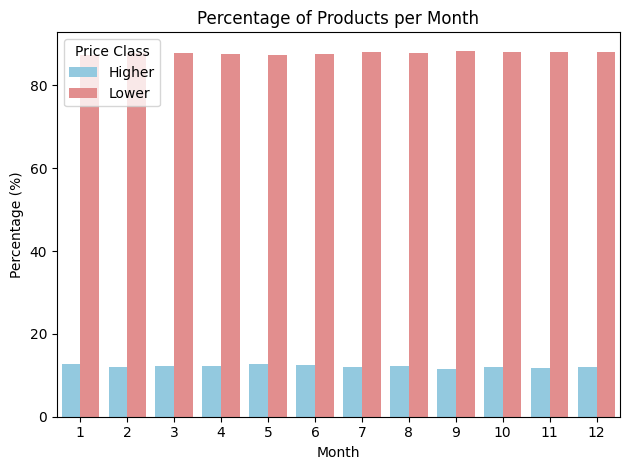

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the percentage per class per month
percentages_df = grouped.div(grouped.sum(axis=1), axis=0) * 100
percentages_df = percentages_df.applymap(lambda x: f'{x:.2f}%')

# Do not reset the index, keep 'Price Class' as the index
# percentages_df = percentages_df.reset_index()

# Melt the DataFrame to have 'Price Class' as a column
percentages_df = percentages_df.reset_index().melt(id_vars='Month', var_name='Price Class', value_name='Percentage')

# Remove '%' sign and convert to numeric
percentages_df['Percentage'] = percentages_df['Percentage'].str.rstrip('%').astype('float')

# Create a bar chart with seaborn, use 'Higher' or 'Lower' instead of 'Percentage'
sns.barplot(data=percentages_df, x="Month", y='Percentage', hue='Price Class', palette=['skyblue', 'lightcoral'])

# Customize the plot using matplotlib
plt.xlabel("Month")
plt.ylabel("Percentage (%)")
plt.title("Percentage of Products per Month")
plt.legend(title="Price Class")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

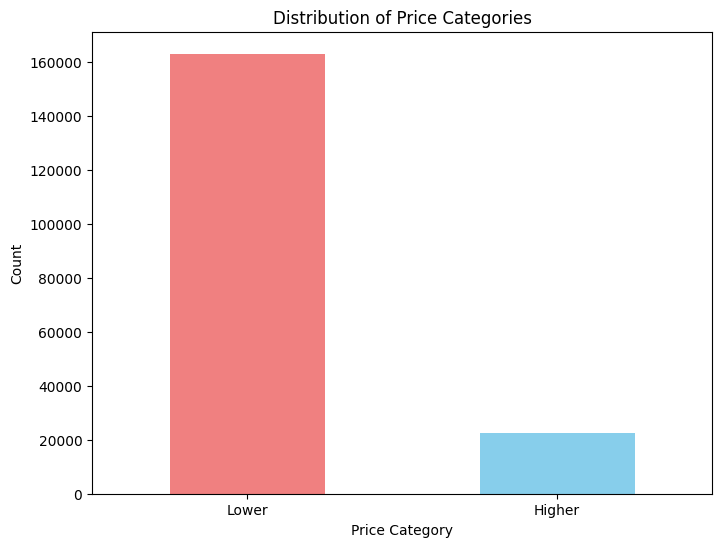

In [108]:
# Plot 'Price Category'
plt.figure(figsize=(8, 6))
combined_df['price_class'].value_counts().plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.title('Distribution of Price Categories')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0)
plt.show()